In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTS and Loading-in Dataset

In [2]:
# IMPORTS
import json
import torch
from transformers import (
    LongformerTokenizer,
    LongformerForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

df = pd.read_csv('/content/drive/My Drive/Political_Bias.csv')
df.columns = df.columns.str.lower()
print('Initial Label counts: \n', df['bias'].value_counts(), '\n')
print('Number of samples: ', len(df))
df.describe()

Initial Label counts: 
 bias
left          1865
lean left      534
right          529
center         319
lean right     211
Name: count, dtype: int64 

Number of samples:  3458


,title,link,text,source,bias
count,3458,3458,3397,3458,3458
unique,3210,2908,2435,21,5
top,Trumpâ€™s Supposed Unity Message Is a Gloating...,https://www.thenation.com/article/politics/tru...,Error fetching article,Alternet,left
freq,7,7,632,1031,1865


# Data Preprocessing and Tokenisation

In [3]:
# Remove irrelevant columns
df = df.drop('link', axis=1)
df = df.drop('title', axis=1)
df = df.drop('source', axis=1)

# Drop rows where:
df.dropna(inplace=True) # there are missing values
df = df[df['text'] != 'Error fetching article'] # the text is an error message
df.drop_duplicates(subset='text', keep='first', inplace=True) # the text is duplicated
df = df[df['text'].str.strip() != ''] # the text is empty or only whitespace

df['length'] = df['text'].apply(lambda x: len(x.split(' ')))
df = df[df['length'] >= 15] # the text is too short

df = df[df['length'] <= 2048] # the text is too long

# LABEL ENCODING AND DATAFRAME PREPARATION
id2label = {0: "left", 1: "lean left", 2: "center", 3: "lean right", 4: "right"}
label2id = {v: k for k, v in id2label.items()}
# model.config.id2label = id2label
# model.config.label2id = label2id

df['label'] = df['bias'].map(label2id) # Convert bias labels to numeric
df = df[['text', 'bias', 'label']] # Keep only relevant columns

# TRAIN/VAL/TEST SPLIT
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Keep class distribution
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']  # Keep class distribution
)

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print('Train Label counts: \n', train_df['bias'].value_counts(), '\n')
print(f"Val: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print('Val Label counts: \n', val_df['bias'].value_counts(), '\n')
print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print('Test Label counts: \n', test_df['bias'].value_counts(), '\n')

# CONVERT TO HUGGING FACE DATASET
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# LOAD MODEL AND TOKENIZER
model_name = "allenai/longformer-base-4096"
tokenizer = LongformerTokenizer.from_pretrained(model_name)

model = LongformerForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

# TOKENIZE DATASET
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        max_length=2048,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']  # Remove text, keep only input_ids, attention_mask, label
)

tokenized_dataset.set_format("torch")
print("\nTokenized dataset:")
print(tokenized_dataset)

# COMPUTE CLASS WEIGHTS (for imbalance)
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2, 3, 4]),
    y=train_df['label'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("\nClass weights:")
for label, weight in zip(id2label.values(), class_weights):
    print(f"  {label}: {weight:.3f}")

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss



Split sizes:
Train: 1890 (80.0%)
Train Label counts: 
 bias
left          949
right         382
lean left     249
center        160
lean right    150
Name: count, dtype: int64 

Val: 236 (10.0%)
Val Label counts: 
 bias
left          119
right          48
lean left      31
center         20
lean right     18
Name: count, dtype: int64 

Test: 237 (10.0%)
Test Label counts: 
 bias
left          119
right          48
lean left      31
center         20
lean right     19
Name: count, dtype: int64 



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1890 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]


Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1890
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 236
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 237
    })
})

Class weights:
  left: 0.398
  lean left: 1.518
  center: 2.362
  lean right: 2.520
  right: 0.990


# Helper Evaluation Functions

In [4]:
def compute_metrics(eval_pred):
    """Metrics computed during training"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate all metrics
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    # Per-class F1
    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,           # PRIMARY METRIC
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
    }

    # Add per-class F1s
    label_names = ['left', 'right', 'lean left', 'center', 'lean right']
    for i, name in enumerate(label_names):
        metrics[f'f1_{name}'] = f1_per_class[i]

    return metrics

def plot_confusion_matrix(true_labels, predictions, label_names, save_path='confusion_matrix.png'):
    """Plot normalized confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=label_names,
        yticklabels=label_names,
        cbar_kws={'label': 'Percentage'}
    )
    plt.title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to {save_path}")
    plt.show()

def analyze_directional_errors(true_labels, predictions, label2id):
    """Analyze political spectrum directional errors"""
    spectrum_order = ['left', 'lean left', 'center', 'lean right', 'right']
    id_to_position = {label2id[l]: i for i, l in enumerate(spectrum_order)}

    errors = []
    for true, pred in zip(true_labels, predictions):
        if true != pred:
            true_pos = id_to_position[true]
            pred_pos = id_to_position[pred]
            distance = abs(true_pos - pred_pos)
            errors.append(distance)

    if errors:
        avg_error_distance = np.mean(errors)
        opposite_errors = sum(1 for d in errors if d >= 3)

        print(f"\nDIRECTIONAL ERROR ANALYSIS:")
        print(f"  Average error distance: {avg_error_distance:.2f}")
        print(f"  (1.0 = adjacent class, 4.0 = opposite end)")
        print(f"  Opposite-end errors: {opposite_errors}/{len(errors)} ({opposite_errors/len(errors)*100:.1f}%)")
        print(f"  Adjacent errors: {sum(1 for d in errors if d == 1)}/{len(errors)} ({sum(1 for d in errors if d == 1)/len(errors)*100:.1f}%)")
    else:
        print("\nPerfect predictions - no errors!")

def full_evaluation(trainer, test_dataset, label_names, label2id, save_prefix=""):
    """Complete evaluation after training"""

    print("\n" + "="*70)
    print("FINAL MODEL EVALUATION")
    print("="*70)

    # Get predictions
    predictions_output = trainer.predict(test_dataset)
    predictions = np.argmax(predictions_output.predictions, axis=1)
    true_labels = predictions_output.label_ids

    # Overall metrics
    print("\nOVERALL METRICS:")
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    precision_macro = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(true_labels, predictions, average='macro', zero_division=0)

    print(f"  Accuracy:          {accuracy:.4f}")
    print(f"  F1-Macro:          {f1_macro:.4f} -> PRIMARY METRIC")
    print(f"  F1-Weighted:       {f1_weighted:.4f}")
    print(f"  Precision-Macro:   {precision_macro:.4f}")
    print(f"  Recall-Macro:      {recall_macro:.4f}")

    # Per-class F1
    f1_per_class = f1_score(true_labels, predictions, average=None, zero_division=0)
    print(f"\nPER-CLASS F1 SCORES:")
    for i, name in enumerate(label_names):
        print(f"  {name:12}: {f1_per_class[i]:.4f}")

    # Classification report
    print("\n" + "="*70)
    print("DETAILED CLASSIFICATION REPORT:")
    print("="*70)
    print(classification_report(
        true_labels,
        predictions,
        target_names=label_names,
        digits=4
    ))

    # Confusion matrix
    print("\n" + "="*70)
    print("CONFUSION MATRIX:")
    print("="*70)
    plot_confusion_matrix(
        true_labels,
        predictions,
        label_names,
        save_path=f'{save_prefix}confusion_matrix.png'
    )

    # Directional errors
    analyze_directional_errors(true_labels, predictions, label2id)

    # Find high-confidence mistakes
    probs = torch.nn.functional.softmax(torch.tensor(predictions_output.predictions), dim=-1)
    confidence = probs.max(dim=1).values.numpy()

    mistakes = predictions != true_labels
    high_conf_mistakes = mistakes & (confidence > 0.8)

    print(f"\nHIGH-CONFIDENCE MISTAKES:")
    print(f"  Total mistakes: {mistakes.sum()}")
    print(f"  High-confidence mistakes (>80%): {high_conf_mistakes.sum()}")
    if high_conf_mistakes.sum() > 0:
        print(f"  (These are worth manually inspecting)")

    # Return summary
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_per_class': dict(zip(label_names, f1_per_class)),
        'total_errors': int(mistakes.sum()),
        'high_conf_errors': int(high_conf_mistakes.sum())
    }

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"\nUsing device: {device}")

# Move model to device
model.to(device)


Using device: cuda


LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

# IA3


Starting IA3 training...


Initializing global attention on CLS token...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,F1 Left,F1 Right,F1 Lean left,F1 Center,F1 Lean right
1,1.539800,1.503775,0.521186,0.302877,0.469958,0.305715,0.313091,0.673835,0.566038,0.000000,0.000000,0.274510
2,1.457100,1.398441,0.567797,0.375389,0.536137,0.372987,0.404849,0.712000,0.511628,0.193548,0.000000,0.459770
3,1.215700,1.264170,0.483051,0.397014,0.474009,0.423809,0.461782,0.528736,0.568421,0.117647,0.266667,0.503597
4,1.093600,1.196373,0.580508,0.466970,0.587818,0.454985,0.494194,0.695238,0.657534,0.238095,0.162162,0.581818
5,0.977800,1.198541,0.563559,0.472226,0.580888,0.464389,0.507659,0.673367,0.657143,0.290909,0.157895,0.581818



IA3 training complete! Time: 92.19 minutes

FINAL MODEL EVALUATION



OVERALL METRICS:
  Accuracy:          0.5148
  F1-Macro:          0.4566 -> PRIMARY METRIC
  F1-Weighted:       0.5246
  Precision-Macro:   0.4554
  Recall-Macro:      0.4805

PER-CLASS F1 SCORES:
  left        : 0.6214
  lean left   : 0.4615
  center      : 0.4545
  lean right  : 0.3030
  right       : 0.4425

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        left     0.7356    0.5378    0.6214       119
   lean left     0.3830    0.5806    0.4615        31
      center     0.4167    0.5000    0.4545        20
  lean right     0.3571    0.2632    0.3030        19
       right     0.3846    0.5208    0.4425        48

    accuracy                         0.5148       237
   macro avg     0.4554    0.4805    0.4566       237
weighted avg     0.5612    0.5148    0.5246       237


CONFUSION MATRIX:
Confusion matrix saved to ia3_confusion_matrix.png


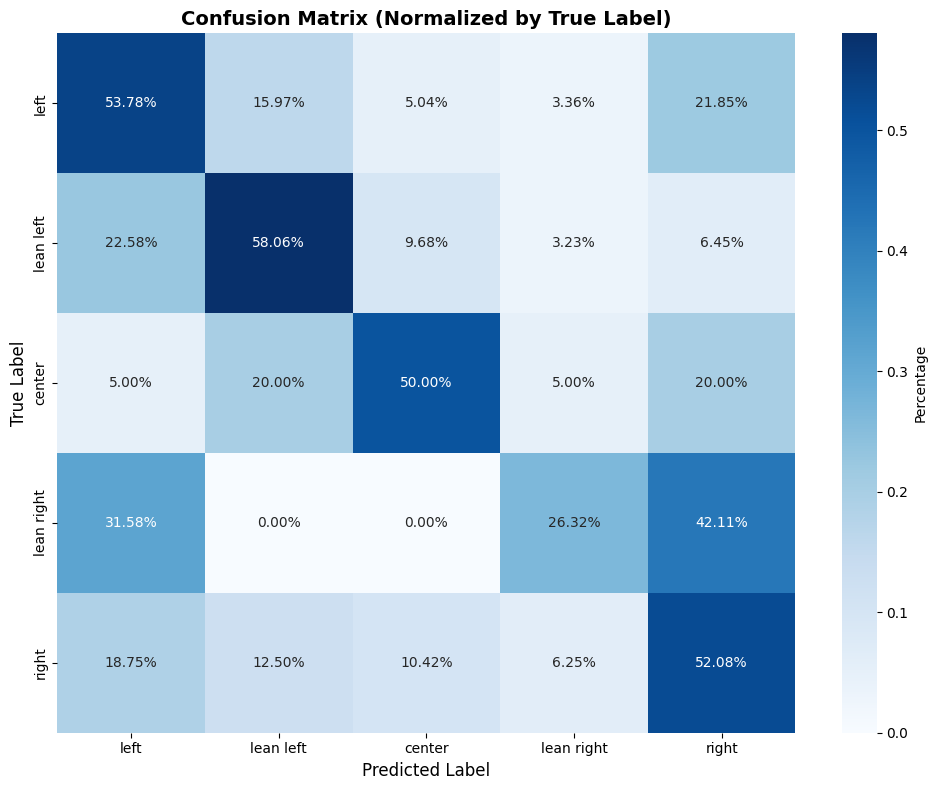


DIRECTIONAL ERROR ANALYSIS:
  Average error distance: 2.37
  (1.0 = adjacent class, 4.0 = opposite end)
  Opposite-end errors: 53/115 (46.1%)
  Adjacent errors: 45/115 (39.1%)

HIGH-CONFIDENCE MISTAKES:
  Total mistakes: 115
  High-confidence mistakes (>80%): 0

IA3 complete! Results saved.


In [7]:
from peft import IA3Config, TaskType, get_peft_model

config = IA3Config(
    peft_type="IA3",
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "key", "value", "w0"],  # Specify modules to apply IA3
    feedforward_modules=["w0"],
)

ia3_model = get_peft_model(model, config)

# Training arguments
ia3_training_args = TrainingArguments(
    output_dir="./longformer_ia3",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=3e-4,
    weight_decay=0.01,
    warmup_steps=500,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    logging_steps=50,
    fp16=True,
    dataloader_num_workers=2,

    seed=42,
    report_to="none",
    save_total_limit=1,
)


ia3_trainer = WeightedLossTrainer(
    model=ia3_model,
    args=ia3_training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

# Train
print("\nStarting IA3 training...")
import time
start_time = time.time()

ia3_trainer.train()

ia3_time = time.time() - start_time
print(f"\nIA3 training complete! Time: {ia3_time/60:.2f} minutes")

# Evaluate
ia3_metrics = full_evaluation(
    ia3_trainer,
    tokenized_dataset['test'],
    list(id2label.values()),
    label2id,
    save_prefix="ia3_"
)

# Save
ia3_trainer.save_model("./longformer_ia3_model")
ia3_metrics['training_time_minutes'] = ia3_time / 60

results1['ia3'] = ia3_metrics

import json
with open('ia3_results.json', 'w') as f:
    json.dump(ia3_metrics, f, indent=2)

print("\nIA3 complete! Results saved.")

# Prompt tuning

In [8]:
from peft import PromptTuningConfig, TaskType, get_peft_model

config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    num_virtual_tokens=20,
    prompt_tuning_init="TEXT",
    prompt_tuning_init_text="Classify the political bias of this article as 0 (left), 1 (lean left), 2 (center), 3 (lean right), 4 (right)",
    tokenizer_name_or_path=model_name,
)

prompt_model = get_peft_model(model, config)

prompt_training_args = TrainingArguments(
    output_dir="./longformer_prompt",
    num_train_epochs=7,  # Prompt tuning often needs more epochs than LoRA
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=32,
    learning_rate=3e-2,  # IMPORTANT: Higher LR for prompt tuning (0.01-0.1)
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",

    # Logging
    logging_dir="./logs/prompt_tuning",
    logging_steps=50,

    # Performance
    fp16=True,  # Mixed precision training
    dataloader_num_workers=4,

    # Reproducibility
    seed=42,
    report_to="none",
    save_total_limit=1,
)

prompt_trainer = WeightedLossTrainer(
    model=ia3_model,
    args=ia3_training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

# Train
print("\nStarting prompt training...")
import time
start_time = time.time()

prompt_trainer.train()

prompt_time = time.time() - start_time
print(f"\nprompt training complete! Time: {prompt_time/60:.2f} minutes")

# Evaluate
prompt_metrics = full_evaluation(
    prompt_trainer,
    tokenized_dataset['test'],
    list(id2label.values()),
    label2id,
    save_prefix="prompt_"
)

# Save
prompt_trainer.save_model("./longformer_prompt_model")
prompt_metrics['training_time_minutes'] = prompt_time / 60

results1['prompt'] = prompt_metrics

import json
with open('prompt_results.json', 'w') as f:
    json.dump(prompt_metrics, f, indent=2)

print("\nprompt complete! Results saved.")

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(


SyntaxError: keyword argument repeated: report_to (ipython-input-3042762807.py, line 39)